In [1]:
library(readxl)
library(dplyr)
library(ggplot2)
library(reshape2)
library('tidyr')
library('tibble')
library("reshape2")
library(sva)
library(readr)
library(DEqMS)
library(pheatmap)
library(gprofiler2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths


Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.

Loading required package: genefilter

Loading required package: BiocParallel


Attaching package: ‘readr’


The following object is masked from ‘package:genefilter’:

    spec


Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:genefilter’:

    rowSds, rowVars


The following object is masked from ‘package:dplyr’:

    count


Loading required package: limma



`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
Rows: 9989 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): mRNA

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Found4batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding nonparametric adjustments

Adjusting the Data




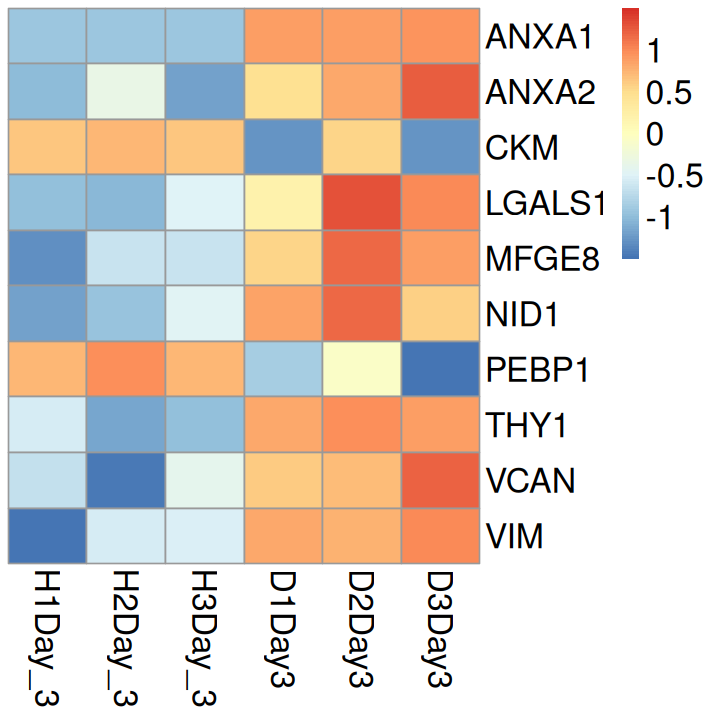

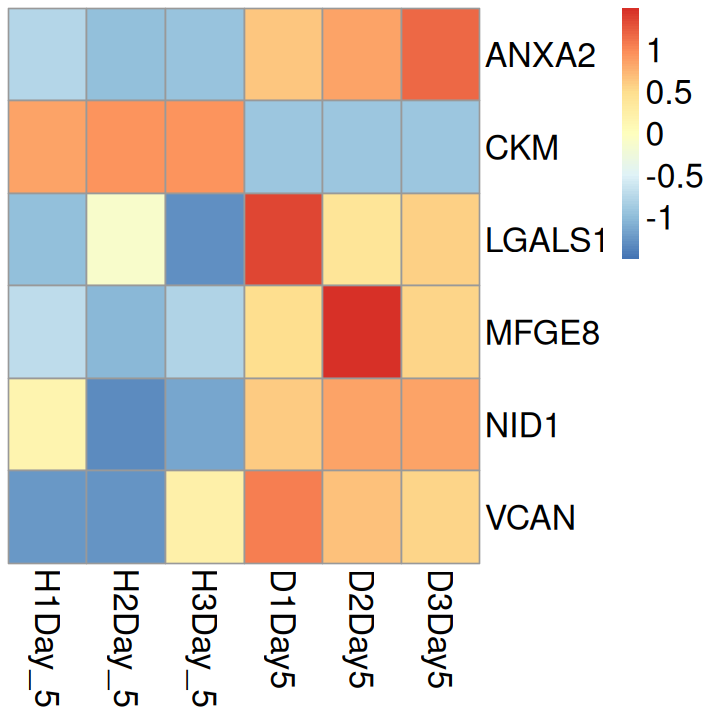

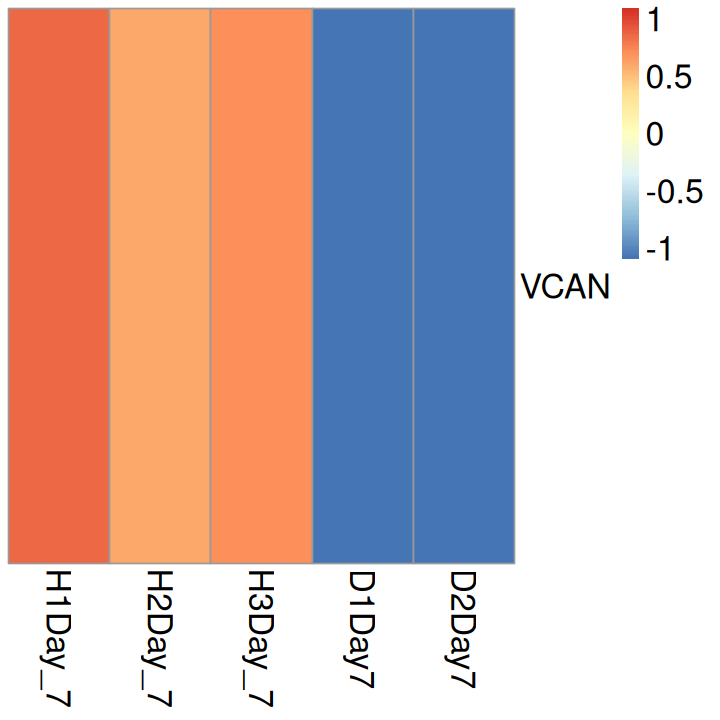

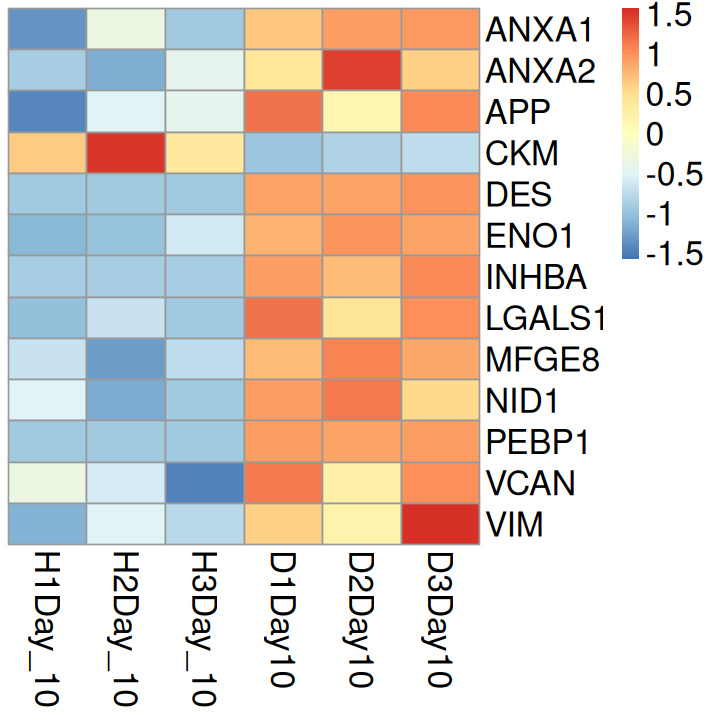

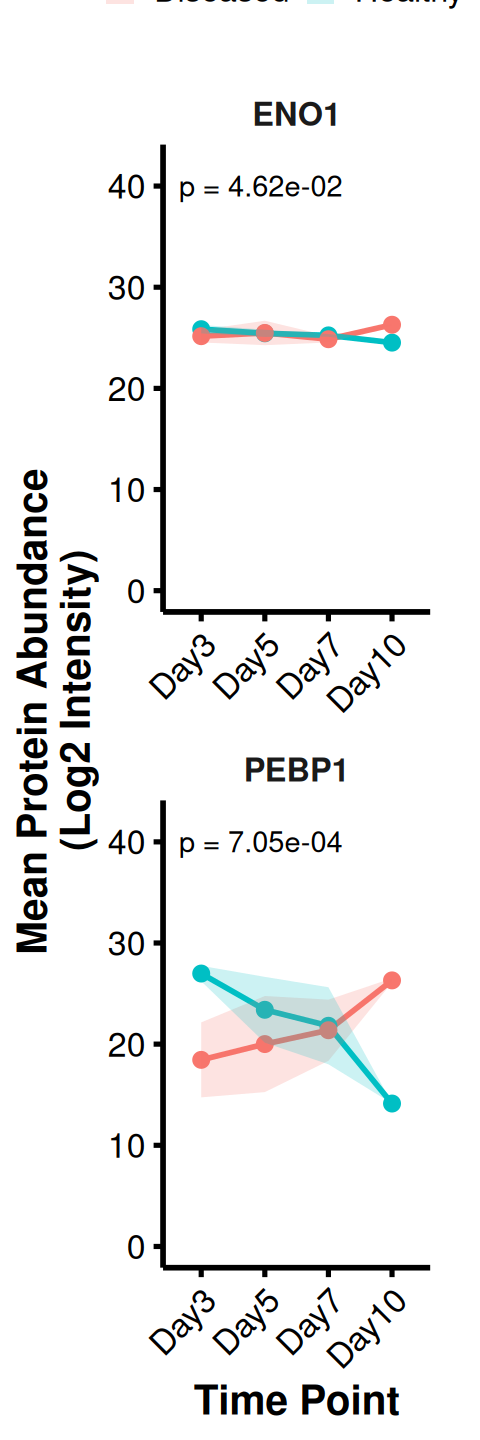

In [15]:
options(repr.plot.width =6, repr.plot.height =6)

d3 <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D3") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  melt(., id.vars="Gene") %>% group_by(Gene, variable) %>%
    summarise(sum_value=sum(value)) %>% dcast(Gene ~ variable, value.var = "sum_value")

d5 <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D5") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  melt(., id.vars="Gene") %>% group_by(Gene, variable) %>%
    summarise(sum_value=sum(value)) %>% dcast(Gene ~ variable, value.var = "sum_value")

d7 <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D7") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  melt(., id.vars="Gene") %>% group_by(Gene, variable) %>%
    summarise(sum_value=sum(value)) %>% dcast(Gene ~ variable, value.var = "sum_value")

d10 <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D10") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  melt(., id.vars="Gene") %>% group_by(Gene, variable) %>%
    summarise(sum_value=sum(value)) %>% dcast(Gene ~ variable, value.var = "sum_value")




d3_ptm <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D3") %>% dplyr::mutate(Gene = toupper(Gene)) %>% group_by(Gene) %>% summarise(median_count = sum(Day3), .groups = "drop")
d5_ptm <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D5") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  group_by(Gene) %>% summarise(median_count = sum(Day5), .groups="drop")
d7_ptm <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D7") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  group_by(Gene) %>% summarise(median_count = sum(Day7), .groups="drop")
d10_ptm <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D10") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  group_by(Gene) %>% summarise(median_count = sum(Day10), .groups="drop")


d3$Day3 = d3_ptm$median_count
d5$Day5 = d5_ptm$median_count
d7$Day7 = d7_ptm$median_count
d10$Day10 = d10_ptm$median_count


d35 <- merge(d3, d5, by='Gene', all=TRUE)
d357 <- merge(d35, d7, by='Gene', all=TRUE) 
d35710 <- merge(d357, d10, by='Gene', all=TRUE)

agg <- d35710 %>%
  dplyr::mutate(across(c(Day3, Day5, Day7, Day10), ~replace_na(., 0))) 

##########
do <- agg %>% dplyr::slice(2:(n() -1)) %>% dplyr::mutate(across(where(is.numeric), ~tidyr::replace_na(., 0)))
mRNA <- read_tsv('VESICLEPEDIA_PROTEIN_MRNAS_5.1.txt')
mRNA_prep <- do[do$Gene %in% mRNA$mRNA, ] 
rownames(mRNA_prep) <- mRNA_prep$Gene
mRNA_prep_rdy <- mRNA_prep[complete.cases(mRNA_prep),] %>% rowwise() %>% filter(mean(c_across(where(is.numeric)) == 0 ) < 0.25) %>% ungroup()

###########
gene <- mRNA_prep_rdy %>% dplyr::select(Gene) 
d3_count <- mRNA_prep_rdy %>% dplyr::select(Day3)+1
d5_count <- mRNA_prep_rdy %>% dplyr::select(Day5)+1
d7_count <- mRNA_prep_rdy %>% dplyr::select(Day7)+1
d10_count <- mRNA_prep_rdy %>% dplyr::select(Day10)+1

rownames(d3_count) <- gene$Gene
rownames(d5_count) <- gene$Gene
rownames(d7_count) <- gene$Gene
rownames(d10_count) <- gene$Gene

colnames(d3_count) <- "count"
colnames(d5_count) <- "count"
colnames(d7_count) <- "count"
colnames(d10_count) <- "count"


prep <- log2(mRNA_prep_rdy %>% dplyr::select(-Gene, -Day3, -Day5, -Day7, -Day10)+1) %>% dplyr::select(c(1:17,19:24))




#then correct for different sequencing batches
batches <- as.factor(c(rep(1, each=6), rep(2, each=6), rep(3, each=5), rep(4, each=6)
                      )
                    )

corrected <- data.frame(ComBat(as.matrix(prep), batch=batches, par.prior=FALSE)) 
row.names(corrected) <- gene$Gene

colnames(corrected) <- c("H1Day_3", "H2Day_3", "H3Day_3", "D1Day3", "D2Day3", "D3Day3",
                        "H1Day_5", "H2Day_5", "H3Day_5", "D1Day5", "D2Day5", "D3Day5",
                        "H1Day_7", "H2Day_7", "H3Day_7", "D1Day7", "D2Day7", 
                        "H1Day_10", "H2Day_10", "H3Day_10", "D1Day10", "D2Day10", "D3Day10"
                        )



TC = as.factor(c(rep('HD3',3), rep('DD3',3),
                 rep('HD5',3), rep('DD5',3),
                 rep('HD7',3), rep('DD7',2),
                 rep('HD10',3), rep('DD10',3))
               )

                 
design = model.matrix(~0 + TC) # fitting without intercept


#######Day3

fit = lmFit(corrected[,c(1:23)], design = design)
cont <- makeContrasts(TCDD3 - TCHD3, levels=design)

fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2, trend=TRUE, robust=TRUE)
fit2$count = d3_count[rownames(fit2$coefficients),"count"]
fit3 = spectraCounteBayes(fit2)
a = outputResult(fit3, coef_col=1) %>% dplyr::filter(sca.adj.pval <= 0.051)
av <- pheatmap(corrected[rownames(corrected) %in% a$gene, 1:6], scale="row", cluster_col=FALSE, cluster_row=FALSE, fontsize=20)$gtable
ggsave('d3heatmap.jpeg', av, dpi=300, width=6, height=6, units="in")



###Day 5
fit = lmFit(corrected[,c(1:23)], design = design)
cont <- makeContrasts(TCDD5 - TCHD5, levels=design)

fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2, trend=TRUE, robust=TRUE)
fit2$count = d5_count[rownames(fit2$coefficients),"count"]
fit3 = spectraCounteBayes(fit2)
b = outputResult(fit3, coef_col=1) %>% dplyr::filter(sca.adj.pval <= 0.051)
bv <- pheatmap(corrected[rownames(corrected) %in% b$gene, 7:12], scale="row", cluster_col=FALSE, cluster_row=FALSE, fontsize=20)$gtable
ggsave('d5heatmap.jpeg', bv, dpi=300, width=6, height=6, units="in")


###Day 7
fit = lmFit(corrected[,c(1:23)], design = design)
cont <- makeContrasts(TCDD7 - TCHD7, levels=design)

fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2, trend=TRUE, robust=TRUE)
fit2$count = d7_count[rownames(fit2$coefficients),"count"]
fit3 = spectraCounteBayes(fit2)
c = outputResult(fit3, coef_col=1) %>% dplyr::filter(sca.adj.pval <= 0.051)
cv <- pheatmap(corrected[rownames(corrected) %in% c$gene, 13:17], scale="row", cluster_col=FALSE, cluster_row=FALSE, fontsize=20)$gtable
ggsave('d7heatmap.jpeg', cv, dpi=300, width=6, height=6, units="in")

###Day 10
fit = lmFit(corrected[,c(1:23)], design = design)
cont <- makeContrasts(TCDD10 - TCHD10, levels=design)

fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2, trend=TRUE, robust=TRUE)
fit2$count = d10_count[rownames(fit2$coefficients),"count"]
fit3 = spectraCounteBayes(fit2)
d = outputResult(fit3, coef_col=1) %>% dplyr::filter(sca.adj.pval <= 0.051)
dv <- pheatmap(corrected[rownames(corrected) %in% d$gene, 18:23], scale="row", cluster_col=FALSE, cluster_row=FALSE, fontsize=20)$gtable
ggsave('d10heatmap.jpeg', dv, dpi=300, width=6, height=6, units="in")


# Combine gene lists
combo <- c(a$gene, b$gene, c$gene, d$gene)

# Subset corrected matrix
subset_corrected <- corrected[rownames(corrected) %in% combo, ]

# Initialize dataframe to store means and SDs
agg_df <- data.frame(Gene = rownames(subset_corrected))

# Define custom column indices for each group
group_indices <- list(
  Group1 = c(1,2,3),     # Day3 Healthy
  Group2 = c(4,5,6),     # Day3 Diseased
  Group3 = c(7,8,9),     # Day5 Healthy
  Group4 = c(10,11,12),  # Day5 Diseased
  Group5 = c(13,14,15),  # Day7 Healthy
  Group6 = c(16,17),     # Day7 Diseased (only 2 samples now)
  Group7 = c(18,19,20),  # Day10 Healthy
  Group8 = c(21,22,23)   # Day10 Diseased
)

# Compute row-wise mean and SD using manual groups
for (group_name in names(group_indices)) {
  cols <- group_indices[[group_name]]
  group_data <- subset_corrected[, cols, drop = FALSE]
  
  agg_df[[paste0(group_name, "_mean")]] <- rowMeans(group_data, na.rm = TRUE)
  agg_df[[paste0(group_name, "_sd")]] <- apply(group_data, 1, sd, na.rm = TRUE)
}

# Reshape to long format
plot_df <- agg_df %>%
  pivot_longer(cols = -Gene, names_to = c("Group", "Stat"),
               names_pattern = "Group(\\d+)_(mean|sd)", values_to = "value") %>%
  pivot_wider(names_from = Stat, values_from = value) %>%
  mutate(
    Group = as.integer(Group),
    Time = case_when(
      Group %in% c(1, 2) ~ "Day3",
      Group %in% c(3, 4) ~ "Day5",
      Group %in% c(5, 6) ~ "Day7",
      Group %in% c(7, 8) ~ "Day10"
    ),
    Class = case_when(
      Group %% 2 == 1 ~ "Healthy",
      Group %% 2 == 0 ~ "Diseased"
    )
  )

# Split Healthy and Diseased
healthy_df <- plot_df %>% filter(Class == "Healthy") %>%
  mutate(TimePoint = Time)

diseased_df <- plot_df %>% filter(Class == "Diseased") %>%
  mutate(TimePoint = Time)

# Pivot to wide format
healthy_wide <- healthy_df %>%
  select(Gene, TimePoint, mean) %>%
  pivot_wider(names_from = Gene, values_from = mean)

diseased_wide <- diseased_df %>%
  select(Gene, TimePoint, mean) %>%
  pivot_wider(names_from = Gene, values_from = mean)

# Transpose to matrices
healthy_mat <- t(healthy_wide[, -1])
diseased_mat <- t(diseased_wide[, -1])
colnames(healthy_mat) <- healthy_wide$TimePoint
colnames(diseased_mat) <- diseased_wide$TimePoint
rownames(healthy_mat) <- colnames(healthy_wide)[-1]
rownames(diseased_mat) <- colnames(diseased_wide)[-1]

# Keep only shared genes
shared_genes <- intersect(rownames(healthy_mat), rownames(diseased_mat))
healthy_mat <- healthy_mat[shared_genes, , drop = FALSE]
diseased_mat <- diseased_mat[shared_genes, , drop = FALSE]

# Slope calculation function
get_slope <- function(df, gene, class = NULL) {
  gene_df <- df %>% filter(Gene == gene)
  if (!is.null(class)) {
    gene_df <- gene_df %>% filter(Class == class)
  }
  if (nrow(gene_df) < 2 || any(is.na(gene_df$mean))) return(NA)
  
  gene_df <- gene_df %>%
    mutate(TimeNum = as.numeric(gsub("Day", "", Time)))
  
  model <- lm(mean ~ TimeNum, data = gene_df)
  return(coef(model)[["TimeNum"]])
}

# ANCOVA interaction p-value
get_ancova_p <- function(df, gene) {
  gene_df <- df %>%
    filter(Gene == gene) %>%
    mutate(TimeNum = as.numeric(gsub("Day", "", Time)))
  
  if (nrow(gene_df) < 6 || any(is.na(gene_df$mean))) return(NA)
  
  model <- lm(mean ~ TimeNum * Class, data = gene_df)
  interaction_p <- anova(model)["TimeNum:Class", "Pr(>F)"]
  return(interaction_p)
}

# Slope ratios + ANCOVA
slope_ratio_df <- tibble(Gene = shared_genes) %>%
  rowwise() %>%
  mutate(
    slope_H = get_slope(healthy_df, Gene),
    slope_D = get_slope(diseased_df, Gene),
    slope_ratio = ifelse(!is.na(slope_H) & !is.na(slope_D) & slope_D != 0,
                         abs(slope_H / slope_D), NA_real_),
    direction = case_when(
      slope_H > 0 & slope_D < 0 ~ "H up, D down",
      slope_H < 0 & slope_D > 0 ~ "H down, D up",
      slope_H > slope_D ~ "H steeper",
      slope_D > slope_H ~ "D steeper",
      TRUE ~ "Similar"
    ),
    ancova_p = get_ancova_p(plot_df, Gene)
 ) %>%
  ungroup() %>%
  mutate(
    signif_stars = case_when(
      ancova_p < 0.001 ~ "***",
      ancova_p < 0.01 ~ "**",
      ancova_p < 0.05 ~ "*",
      TRUE ~ ""
    ),
    p_value_label = ifelse(!is.na(ancova_p),
                           paste0("p = ", formatC(ancova_p, format = "e", digits = 2)),
                           "p = NA"),
    label = paste0(p_value_label)
  ) %>%
  arrange(ancova_p)

# Merge both label and stars into plot_df
plot_df_labeled <- plot_df %>%
  left_join(slope_ratio_df %>% dplyr::filter(ancova_p < 0.05) %>% select(Gene, label, signif_stars) , by = "Gene") %>%  dplyr::filter(!is.na(label))

options(repr.plot.width =4, repr.plot.height =12)

p <- ggplot(plot_df_labeled, aes(x = factor(Time, levels=c("Day3","Day5","Day7","Day10")), y = mean, color = Class, group = Class)) +
  geom_line(size = 1.2) +
  geom_point(size = 4) +
  geom_ribbon(aes(ymin = mean - sd, ymax = mean + sd, fill = Class),
              alpha = 0.2, color = NA) +
  # Add regular labels
  geom_text(data = . %>% group_by(Gene) %>% slice(1),
            aes(x = 0.65, y = 40, label = label),
            inherit.aes = FALSE, hjust = 0, size = 6) +
  facet_wrap(~ Gene, scales = "free", ncol = 1) +
  labs(
    x = "Time Point",
    y = "Mean Protein Abundance \n (Log2 Intensity)",
    color="Culture",
    group="Culture",
    fill="Culture"
  ) +
  theme_minimal(base_size = 24) +
  coord_cartesian(ylim = c(0, 42)) +
  theme(
    panel.grid = element_blank(),
    strip.text = element_text(face = "bold"),
    axis.line = element_line(size = 1.2, color = "black"),
    axis.line.y.right = element_blank(),
    axis.line.x.top = element_blank(),
    axis.ticks.length = unit(2, "mm"),
    axis.ticks = element_line(color = "black"),
    axis.title.x = element_text(face = "bold", size = 24, color = "black"),
    axis.title.y = element_text(face = "bold", size = 24, color = "black"),
    axis.text.x = element_text(size = 20, color = "black", angle = 45, hjust = 1),
    axis.text.y = element_text(size = 20, color = "black"),
    legend.position = c(0.45, 1.22),
    legend.justification = c("center", "top"),
  plot.margin = margin(t = 50, r = 30, b = 10, l = 10)  # top margin added
  )+
guides(
  color = guide_legend(ncol = 2, title.position="top", title.hjust=0.5),
  fill = guide_legend(ncol = 2, title.position="top", title.hjust=0.5),
  group = guide_legend(ncol=2, title.position="top", title.hjust=0.5)  
)
#ggsave("time_series.jpeg", p,  dpi=300, height=9, width=4, unit="in")
p

Warning message in y.pred - digamma(df/2):
“longer object length is not a multiple of shorter object length”


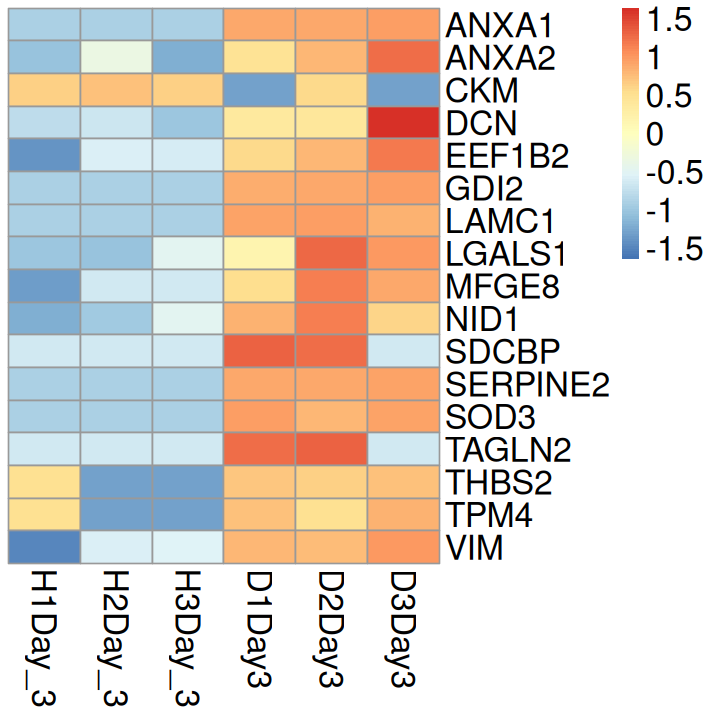

In [30]:
#######Day3

fit = lmFit(t_x[,c(1:23)], design = design)
cont <- makeContrasts(TCDD3 - TCHD3, levels=design)

fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2, trend=TRUE, robust=TRUE)
fit2$count = d3_count[rownames(fit2$coefficients),"count"]
fit3 = spectraCounteBayes(fit2)
a = outputResult(fit3, coef_col=1) %>% dplyr::filter(sca.adj.pval <= 0.051)
av <- pheatmap(t_x[rownames(t_x) %in% a$gene, 1:6], scale="row", cluster_col=FALSE, cluster_row=FALSE, fontsize=20)$gtable
#ggsave('d3heatmap.jpeg', av, dpi=300, width=6, height=6, units="in")


Warning message in y.pred - digamma(df/2):
“longer object length is not a multiple of shorter object length”
Warning message in y.pred - digamma(df/2):
“longer object length is not a multiple of shorter object length”


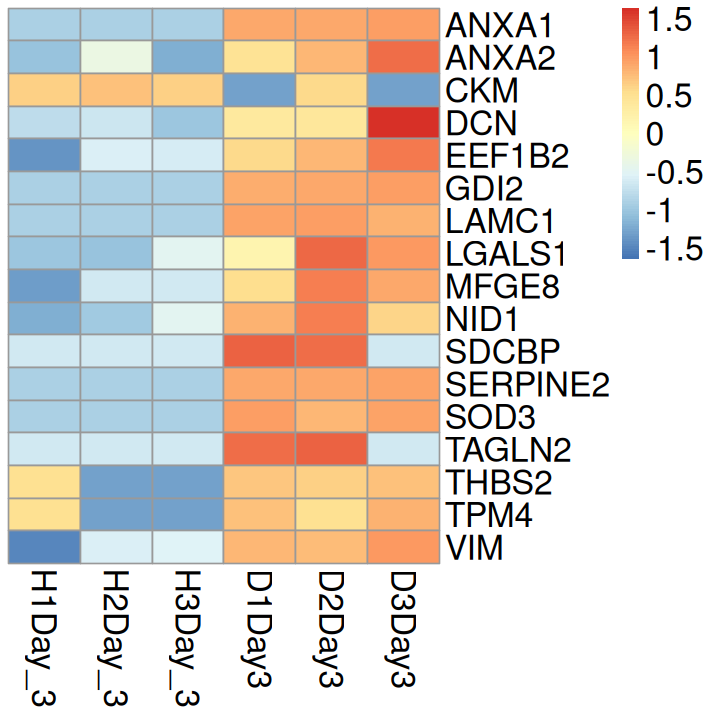

Warning message in y.pred - digamma(df/2):
“longer object length is not a multiple of shorter object length”


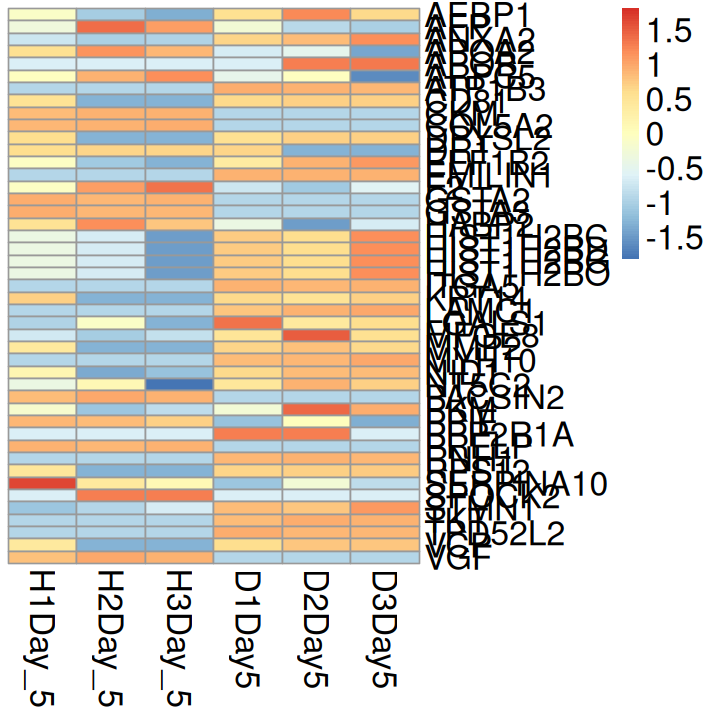

Warning message in y.pred - digamma(df/2):
“longer object length is not a multiple of shorter object length”


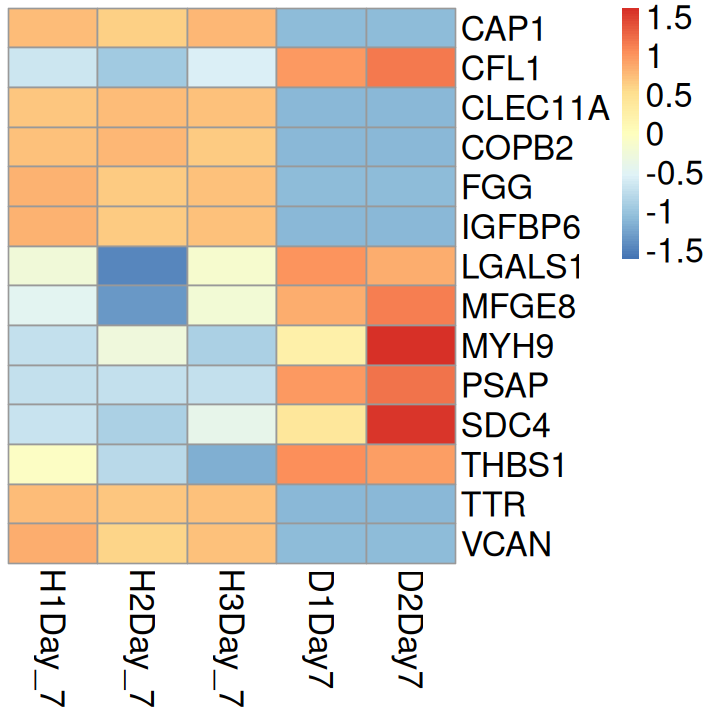

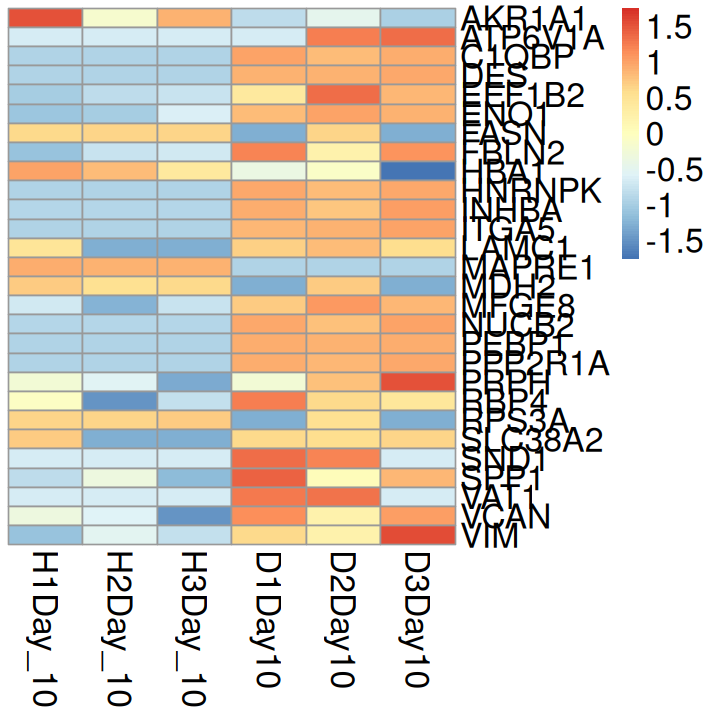

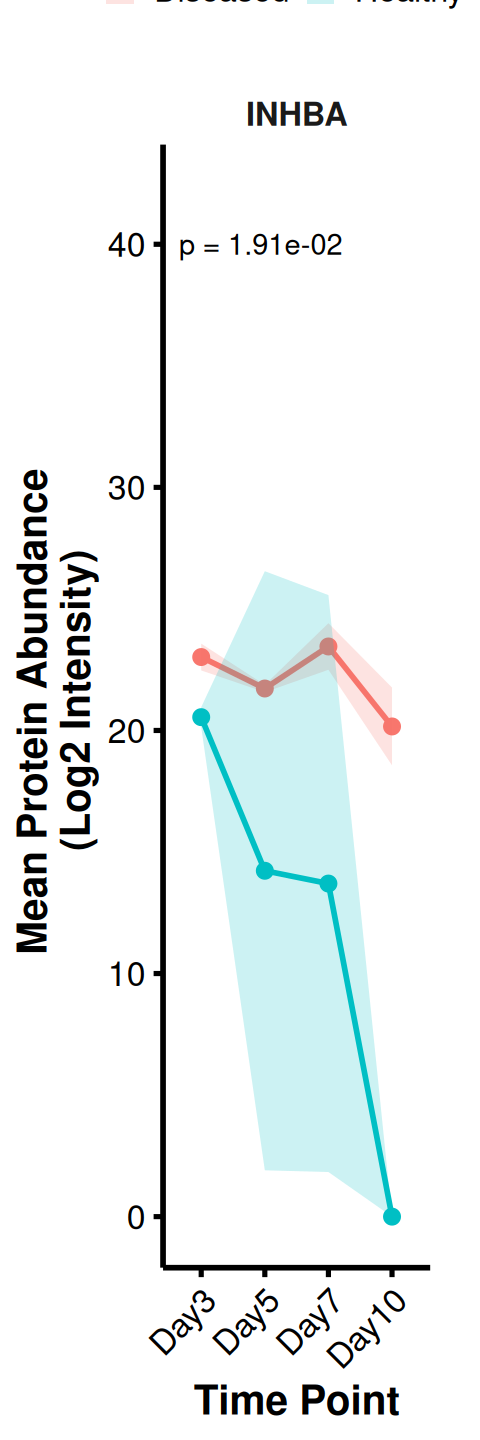

In [37]:

#######Day3

fit = lmFit(t_x[,c(1:23)], design = design)
cont <- makeContrasts(TCDD3 - TCHD3, levels=design)

fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2, trend=TRUE, robust=TRUE)
fit2$count = d3_count[rownames(fit2$coefficients),"count"]
fit3 = spectraCounteBayes(fit2)
a = outputResult(fit3, coef_col=1) %>% dplyr::filter(sca.adj.pval <= 0.051)
av <- pheatmap(t_x[rownames(t_x) %in% a$gene, 1:6], scale="row", cluster_col=FALSE, cluster_row=FALSE, fontsize=20)$gtable
#ggsave('d3heatmap.jpeg', av, dpi=300, width=6, height=6, units="in")



###Day 5
fit = lmFit(t_x[,c(1:23)], design = design)
cont <- makeContrasts(TCDD5 - TCHD5, levels=design)

fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2, trend=TRUE, robust=TRUE)
fit2$count = d5_count[rownames(fit2$coefficients),"count"]
fit3 = spectraCounteBayes(fit2)
b = outputResult(fit3, coef_col=1) %>% dplyr::filter(sca.adj.pval <= 0.051)
bv <- pheatmap(t_x[rownames(t_x) %in% b$gene, 7:12], scale="row", cluster_col=FALSE, cluster_row=FALSE, fontsize=20)$gtable
#ggsave('d5heatmap.jpeg', bv, dpi=300, width=6, height=6, units="in")


###Day 7
fit = lmFit(t_x[,c(1:23)], design = design)
cont <- makeContrasts(TCDD7 - TCHD7, levels=design)

fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2, trend=TRUE, robust=TRUE)
fit2$count = d7_count[rownames(fit2$coefficients),"count"]
fit3 = spectraCounteBayes(fit2)
c = outputResult(fit3, coef_col=1) %>% dplyr::filter(sca.adj.pval <= 0.051)
cv <- pheatmap(t_x[rownames(t_x) %in% c$gene, 13:17], scale="row", cluster_col=FALSE, cluster_row=FALSE, fontsize=20)$gtable
#ggsave('d7heatmap.jpeg', cv, dpi=300, width=6, height=6, units="in")

###Day 10
fit = lmFit(t_x[,c(1:23)], design = design)
cont <- makeContrasts(TCDD10 - TCHD10, levels=design)

fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2, trend=TRUE, robust=TRUE)
fit2$count = d10_count[rownames(fit2$coefficients),"count"]
fit3 = spectraCounteBayes(fit2)
d = outputResult(fit3, coef_col=1) %>% dplyr::filter(sca.adj.pval <= 0.051)
dv <- pheatmap(t_x[rownames(t_x) %in% d$gene, 18:23], scale="row", cluster_col=FALSE, cluster_row=FALSE, fontsize=20)$gtable
#ggsave('d10heatmap.jpeg', dv, dpi=300, width=6, height=6, units="in")


# Combine gene lists
combo <- c(a$gene, b$gene, c$gene, d$gene)

# Subset t_x matrix
subset_t_x <- t_x[rownames(t_x) %in% combo, ]

# Initialize dataframe to store means and SDs
agg_df <- data.frame(Gene = rownames(subset_t_x))

# Define custom column indices for each group
group_indices <- list(
  Group1 = c(1,2,3),     # Day3 Healthy
  Group2 = c(4,5,6),     # Day3 Diseased
  Group3 = c(7,8,9),     # Day5 Healthy
  Group4 = c(10,11,12),  # Day5 Diseased
  Group5 = c(13,14,15),  # Day7 Healthy
  Group6 = c(16,17),     # Day7 Diseased (only 2 samples now)
  Group7 = c(18,19,20),  # Day10 Healthy
  Group8 = c(21,22,23)   # Day10 Diseased
)

# Compute row-wise mean and SD using manual groups
for (group_name in names(group_indices)) {
  cols <- group_indices[[group_name]]
  group_data <- subset_t_x[, cols, drop = FALSE]
  
  agg_df[[paste0(group_name, "_mean")]] <- rowMeans(group_data, na.rm = TRUE)
  agg_df[[paste0(group_name, "_sd")]] <- apply(group_data, 1, sd, na.rm = TRUE)
}

# Reshape to long format
plot_df <- agg_df %>%
  pivot_longer(cols = -Gene, names_to = c("Group", "Stat"),
               names_pattern = "Group(\\d+)_(mean|sd)", values_to = "value") %>%
  pivot_wider(names_from = Stat, values_from = value) %>%
  mutate(
    Group = as.integer(Group),
    Time = case_when(
      Group %in% c(1, 2) ~ "Day3",
      Group %in% c(3, 4) ~ "Day5",
      Group %in% c(5, 6) ~ "Day7",
      Group %in% c(7, 8) ~ "Day10"
    ),
    Class = case_when(
      Group %% 2 == 1 ~ "Healthy",
      Group %% 2 == 0 ~ "Diseased"
    )
  )

# Split Healthy and Diseased
healthy_df <- plot_df %>% filter(Class == "Healthy") %>%
  mutate(TimePoint = Time)

diseased_df <- plot_df %>% filter(Class == "Diseased") %>%
  mutate(TimePoint = Time)

# Pivot to wide format
healthy_wide <- healthy_df %>%
  select(Gene, TimePoint, mean) %>%
  pivot_wider(names_from = Gene, values_from = mean)

diseased_wide <- diseased_df %>%
  select(Gene, TimePoint, mean) %>%
  pivot_wider(names_from = Gene, values_from = mean)

# Transpose to matrices
healthy_mat <- t(healthy_wide[, -1])
diseased_mat <- t(diseased_wide[, -1])
colnames(healthy_mat) <- healthy_wide$TimePoint
colnames(diseased_mat) <- diseased_wide$TimePoint
rownames(healthy_mat) <- colnames(healthy_wide)[-1]
rownames(diseased_mat) <- colnames(diseased_wide)[-1]

# Keep only shared genes
shared_genes <- intersect(rownames(healthy_mat), rownames(diseased_mat))
healthy_mat <- healthy_mat[shared_genes, , drop = FALSE]
diseased_mat <- diseased_mat[shared_genes, , drop = FALSE]

# Slope calculation function
get_slope <- function(df, gene, class = NULL) {
  gene_df <- df %>% filter(Gene == gene)
  if (!is.null(class)) {
    gene_df <- gene_df %>% filter(Class == class)
  }
  if (nrow(gene_df) < 2 || any(is.na(gene_df$mean))) return(NA)
  
  gene_df <- gene_df %>%
    mutate(TimeNum = as.numeric(gsub("Day", "", Time)))
  
  model <- lm(mean ~ TimeNum, data = gene_df)
  return(coef(model)[["TimeNum"]])
}

# ANCOVA interaction p-value
get_ancova_p <- function(df, gene) {
  gene_df <- df %>%
    filter(Gene == gene) %>%
    mutate(TimeNum = as.numeric(gsub("Day", "", Time)))
  
  if (nrow(gene_df) < 6 || any(is.na(gene_df$mean))) return(NA)
  
  model <- lm(mean ~ TimeNum * Class, data = gene_df)
  interaction_p <- anova(model)["TimeNum:Class", "Pr(>F)"]
  return(interaction_p)
}

# Slope ratios + ANCOVA
slope_ratio_df <- tibble(Gene = shared_genes) %>%
  rowwise() %>%
  mutate(
    slope_H = get_slope(healthy_df, Gene),
    slope_D = get_slope(diseased_df, Gene),
    slope_ratio = ifelse(!is.na(slope_H) & !is.na(slope_D) & slope_D != 0,
                         abs(slope_H / slope_D), NA_real_),
    direction = case_when(
      slope_H > 0 & slope_D < 0 ~ "H up, D down",
      slope_H < 0 & slope_D > 0 ~ "H down, D up",
      slope_H > slope_D ~ "H steeper",
      slope_D > slope_H ~ "D steeper",
      TRUE ~ "Similar"
    ),
    ancova_p = get_ancova_p(plot_df, Gene)
 ) %>%
  ungroup() %>%
  mutate(
    signif_stars = case_when(
      ancova_p < 0.001 ~ "***",
      ancova_p < 0.01 ~ "**",
      ancova_p < 0.05 ~ "*",
      TRUE ~ ""
    ),
    p_value_label = ifelse(!is.na(ancova_p),
                           paste0("p = ", formatC(ancova_p, format = "e", digits = 2)),
                           "p = NA"),
    label = paste0(p_value_label)
  ) %>%
  arrange(ancova_p)

# Merge both label and stars into plot_df
plot_df_labeled <- plot_df %>%
  left_join(slope_ratio_df %>% dplyr::filter(ancova_p < 0.05) %>% select(Gene, label, signif_stars) , by = "Gene") %>%  dplyr::filter(!is.na(label))

options(repr.plot.width =4, repr.plot.height =12)

p <- ggplot(plot_df_labeled, aes(x = factor(Time, levels=c("Day3","Day5","Day7","Day10")), y = mean, color = Class, group = Class)) +
  geom_line(size = 1.2) +
  geom_point(size = 4) +
  geom_ribbon(aes(ymin = mean - sd, ymax = mean + sd, fill = Class),
              alpha = 0.2, color = NA) +
  # Add regular labels
  geom_text(data = . %>% group_by(Gene) %>% slice(1),
            aes(x = 0.65, y = 40, label = label),
            inherit.aes = FALSE, hjust = 0, size = 6) +
  facet_wrap(~ Gene, scales = "free", ncol = 1) +
  labs(
    x = "Time Point",
    y = "Mean Protein Abundance \n (Log2 Intensity)",
    color="Culture",
    group="Culture",
    fill="Culture"
  ) +
  theme_minimal(base_size = 24) +
  coord_cartesian(ylim = c(0, 42)) +
  theme(
    panel.grid = element_blank(),
    strip.text = element_text(face = "bold"),
    axis.line = element_line(size = 1.2, color = "black"),
    axis.line.y.right = element_blank(),
    axis.line.x.top = element_blank(),
    axis.ticks.length = unit(2, "mm"),
    axis.ticks = element_line(color = "black"),
    axis.title.x = element_text(face = "bold", size = 24, color = "black"),
    axis.title.y = element_text(face = "bold", size = 24, color = "black"),
    axis.text.x = element_text(size = 20, color = "black", angle = 45, hjust = 1),
    axis.text.y = element_text(size = 20, color = "black"),
    legend.position = c(0.45, 1.22),
    legend.justification = c("center", "top"),
  plot.margin = margin(t = 50, r = 30, b = 10, l = 10)  # top margin added
  )+
guides(
  color = guide_legend(ncol = 2, title.position="top", title.hjust=0.5),
  fill = guide_legend(ncol = 2, title.position="top", title.hjust=0.5),
  group = guide_legend(ncol=2, title.position="top", title.hjust=0.5)  
)
ggsave("time_series_test.jpeg", p,  dpi=300, height=9, width=4, unit="in")
p

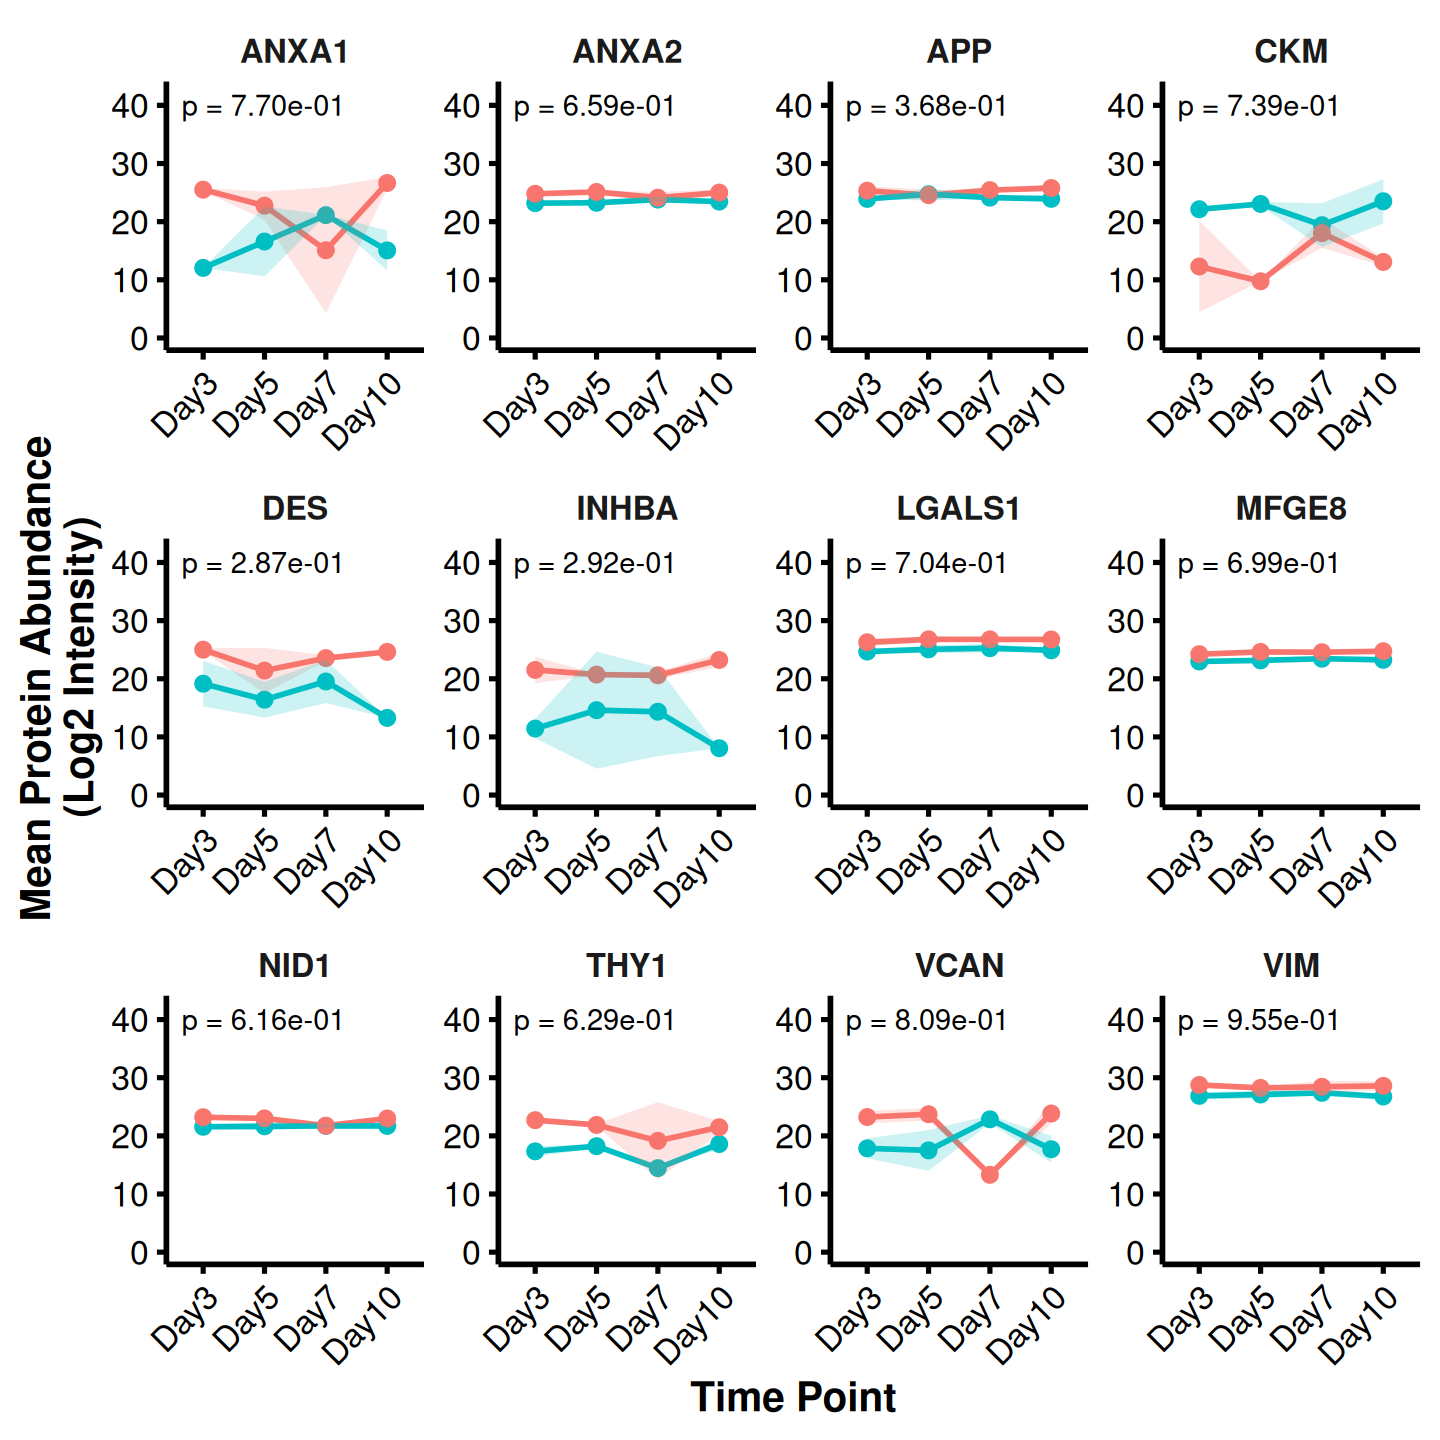

In [20]:
options(repr.plot.width =12, repr.plot.height =12)
# Merge both label and stars into plot_df
plot_df_labeled <- plot_df %>%
  left_join(slope_ratio_df %>% dplyr::filter(ancova_p > 0.05) %>% select(Gene, label, signif_stars) , by = "Gene") %>%  dplyr::filter(!is.na(label))


p <- ggplot(plot_df_labeled, aes(x = factor(Time, levels=c("Day3","Day5","Day7","Day10")), y = mean, color = Class, group = Class)) +
  geom_line(size = 1.2) +
  geom_point(size = 4) +
  geom_ribbon(aes(ymin = mean - sd, ymax = mean + sd, fill = Class),
              alpha = 0.2, color = NA) +
  # Add regular labels
  geom_text(data = . %>% group_by(Gene) %>% slice(1),
            aes(x = 0.65, y = 40, label = label),
            inherit.aes = FALSE, hjust = 0, size = 6) +
  facet_wrap(~ Gene, scales = "free", ncol = 4) +
  labs(
    x = "Time Point",
    y = "Mean Protein Abundance \n (Log2 Intensity)",
    color="Culture",
    group="Culture",
    fill="Culture"
  ) +
  theme_minimal(base_size = 24) +
  coord_cartesian(ylim = c(0, 42)) +
  theme(
    panel.grid = element_blank(),
    strip.text = element_text(face = "bold"),
    axis.line = element_line(size = 1.2, color = "black"),
    axis.line.y.right = element_blank(),
    axis.line.x.top = element_blank(),
    axis.ticks.length = unit(2, "mm"),
    axis.ticks = element_line(color = "black"),
    axis.title.x = element_text(face = "bold", size = 24, color = "black"),
    axis.title.y = element_text(face = "bold", size = 24, color = "black"),
    axis.text.x = element_text(size = 20, color = "black", angle = 45, hjust = 1),
    axis.text.y = element_text(size = 20, color = "black"),
    legend.position = c(0.45, 1.22),
    legend.justification = c("center", "top"),
  #plot.margin = margin(t = 50, r = 30, b = 10, l = 10)  # top margin added
  )+
guides(
  color = guide_legend(ncol = 2, title.position="top", title.hjust=0.5),
  fill = guide_legend(ncol = 2, title.position="top", title.hjust=0.5),
  group = guide_legend(ncol=2, title.position="top", title.hjust=0.5)  
)
ggsave("time_series_ns.jpeg", p,  dpi=300, height=12, width=12, unit="in")
p

In [22]:
# Run gProfiler on the extracted rownames
gostres <- gost(query = c("ENO1","PEBP1"), 
                organism = "hsapiens", 
                ordered_query = FALSE, 
                multi_query = FALSE, 
                significant = TRUE, 
                exclude_iea = FALSE, 
                measure_underrepresentation = FALSE, 
                evcodes = TRUE, 
                user_threshold = 0.05, 
                correction_method = "fdr", 
                domain_scope = "known", 
                numeric_ns = "", 
                as_short_link = FALSE, 
                highlight = TRUE)
      
      
    

gostres$result %>% dplyr::select(-parents, -highlighted)
#write.csv('enriched_pathways.csv')


query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,evidence_codes,intersection
<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
query_1,TRUE,0.007428235,10,2,1,0.5,0.100000000,GO:1990144,GO:BP,intrinsic apoptotic signaling pathway in response to hypoxia,63086,25094,IDA IGI,ENO1
query_1,TRUE,0.007428235,18,2,1,0.5,0.055555556,GO:0006735,GO:BP,NADH regeneration,63086,2436,IDA IMP TAS,ENO1
query_1,TRUE,0.007428235,7,2,1,0.5,0.142857143,GO:1903297,GO:BP,regulation of hypoxia-induced intrinsic apoptotic signaling pathway,63086,22886,IDA IGI,ENO1
query_1,TRUE,0.007428235,640,2,2,1.0,0.003125000,GO:1902532,GO:BP,negative regulation of intracellular signal transduction,63086,22341,"IDA IGI,IBA","ENO1,PEBP1"
query_1,TRUE,0.007428235,14,2,1,0.5,0.071428571,GO:1900373,GO:BP,positive regulation of purine nucleotide biosynthetic process,63086,20624,IDA IGI,ENO1
query_1,TRUE,0.007428235,22,2,1,0.5,0.045454545,GO:1900371,GO:BP,regulation of purine nucleotide biosynthetic process,63086,20622,IDA IGI,ENO1
query_1,TRUE,0.007428235,11,2,1,0.5,0.090909091,GO:1900038,GO:BP,negative regulation of cellular response to hypoxia,63086,20344,IDA IGI,ENO1
query_1,TRUE,0.007428235,18,2,1,0.5,0.055555556,GO:1900037,GO:BP,regulation of cellular response to hypoxia,63086,20343,IDA IGI,ENO1
query_1,TRUE,0.007428235,18,2,1,0.5,0.055555556,GO:0061718,GO:BP,glucose catabolic process to pyruvate,63086,15628,IDA IMP TAS,ENO1


`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
Rows: 9989 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): mRNA

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Found3batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding nonparametric adjustments

Adjusting the Data




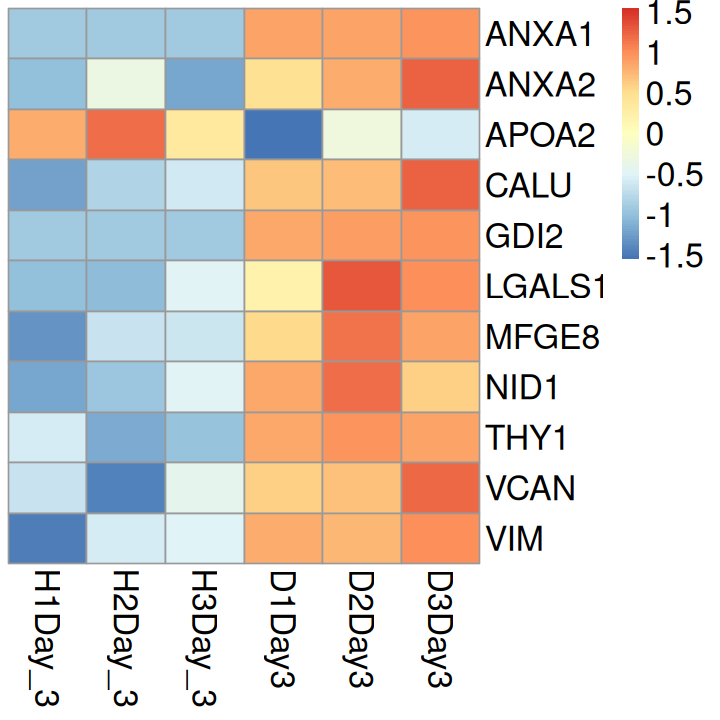

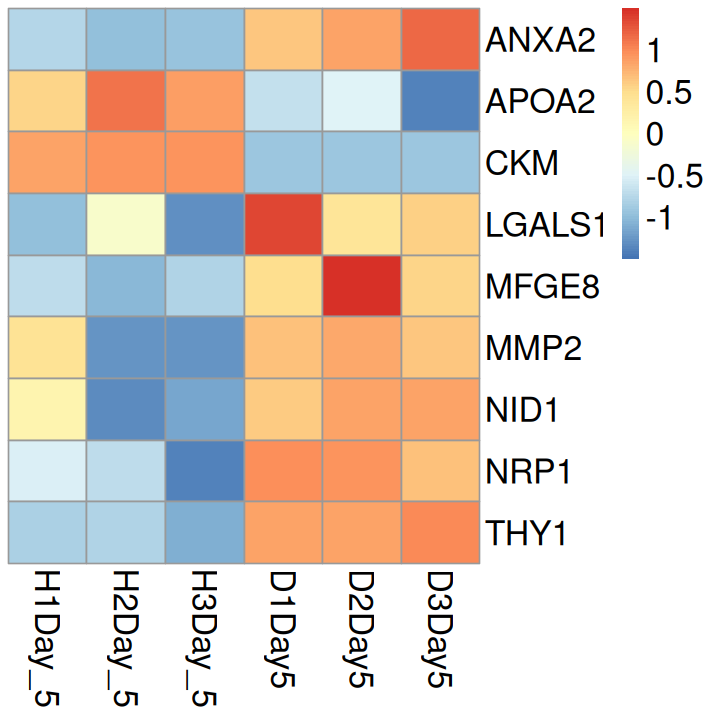

ERROR: Error in `[.data.frame`(subset_corrected, , cols, drop = FALSE): undefined columns selected


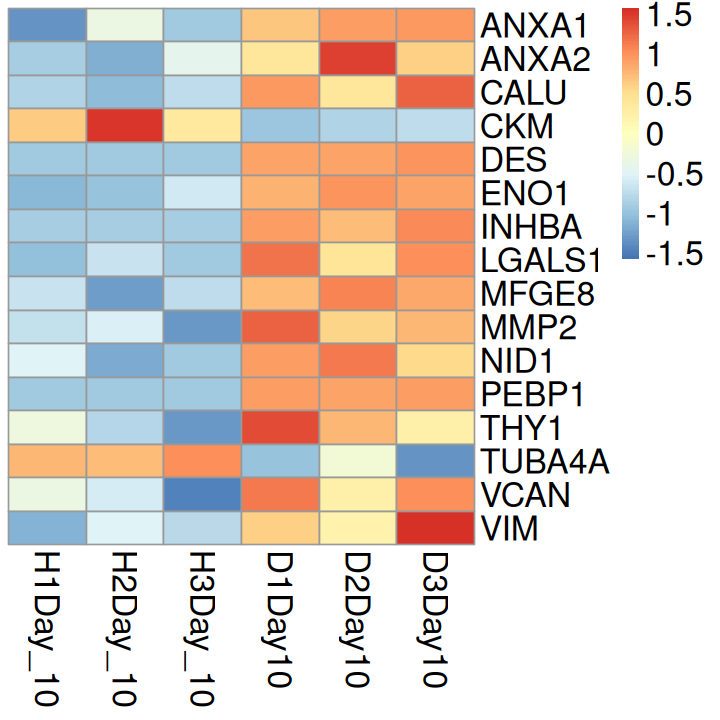

In [15]:
options(repr.plot.width =6, repr.plot.height =6)

d3 <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D3") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  melt(., id.vars="Gene") %>% group_by(Gene, variable) %>%
    summarise(sum_value=sum(value)) %>% dcast(Gene ~ variable, value.var = "sum_value")

d5 <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D5") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  melt(., id.vars="Gene") %>% group_by(Gene, variable) %>%
    summarise(sum_value=sum(value)) %>% dcast(Gene ~ variable, value.var = "sum_value")

d7 <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D7") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  melt(., id.vars="Gene") %>% group_by(Gene, variable) %>%
    summarise(sum_value=sum(value)) %>% dcast(Gene ~ variable, value.var = "sum_value")

d10 <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D10") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  melt(., id.vars="Gene") %>% group_by(Gene, variable) %>%
    summarise(sum_value=sum(value)) %>% dcast(Gene ~ variable, value.var = "sum_value")




d3_ptm <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D3") %>% dplyr::mutate(Gene = toupper(Gene)) %>% group_by(Gene) %>% summarise(median_count = sum(Day3), .groups = "drop")
d5_ptm <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D5") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  group_by(Gene) %>% summarise(median_count = sum(Day5), .groups="drop")
d7_ptm <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D7") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  group_by(Gene) %>% summarise(median_count = sum(Day7), .groups="drop")
d10_ptm <- read_excel('062022025_proteomics_kb_v2.xlsx', sheet="D10") %>% dplyr::mutate(Gene = toupper(Gene)) %>%  group_by(Gene) %>% summarise(median_count = sum(Day10), .groups="drop")


d3$Day3 = d3_ptm$median_count
d5$Day5 = d5_ptm$median_count
d7$Day7 = d7_ptm$median_count
d10$Day10 = d10_ptm$median_count


d35 <- merge(d3, d5, by='Gene', all=TRUE)
d357 <- merge(d35, d7, by='Gene', all=TRUE) 
d35710 <- merge(d357, d10, by='Gene', all=TRUE)

agg <- d35710 %>%
  dplyr::mutate(across(c(Day3, Day5, Day7, Day10), ~replace_na(., 0))) 

##########
do <- agg %>% dplyr::slice(2:(n() -1)) %>% dplyr::mutate(across(where(is.numeric), ~tidyr::replace_na(., 0)))
mRNA <- read_tsv('VESICLEPEDIA_PROTEIN_MRNAS_5.1.txt')
mRNA_prep <- do[do$Gene %in% mRNA$mRNA, ] 
rownames(mRNA_prep) <- mRNA_prep$Gene
mRNA_prep_rdy <- mRNA_prep[complete.cases(mRNA_prep),] %>% rowwise() %>% filter(mean(c_across(where(is.numeric)) == 0 ) < 0.25) %>% ungroup()

###########
gene <- mRNA_prep_rdy %>% dplyr::select(Gene) 
d3_count <- mRNA_prep_rdy %>% dplyr::select(Day3)+1
d5_count <- mRNA_prep_rdy %>% dplyr::select(Day5)+1
d7_count <- mRNA_prep_rdy %>% dplyr::select(Day7)+1
d10_count <- mRNA_prep_rdy %>% dplyr::select(Day10)+1

rownames(d3_count) <- gene$Gene
rownames(d5_count) <- gene$Gene
rownames(d7_count) <- gene$Gene
rownames(d10_count) <- gene$Gene

colnames(d3_count) <- "count"
colnames(d5_count) <- "count"
colnames(d7_count) <- "count"
colnames(d10_count) <- "count"


prep <- log2(mRNA_prep_rdy %>% dplyr::select(-Gene, -Day3, -Day5, -Day7, -Day10)+1) %>% dplyr::select(c(1:12,19:24))




#then correct for different sequencing batches
batches <- as.factor(c(rep(1, each=6), rep(2, each=6),  rep(3, each=6)
                      )
                    )

corrected <- data.frame(ComBat(as.matrix(prep), batch=batches, par.prior=FALSE)) 
row.names(corrected) <- gene$Gene

colnames(corrected) <- c("H1Day_3", "H2Day_3", "H3Day_3", "D1Day3", "D2Day3", "D3Day3",
                        "H1Day_5", "H2Day_5", "H3Day_5", "D1Day5", "D2Day5", "D3Day5",
                        #"H1Day_7", "H2Day_7", "H3Day_7", "D1Day7", "D2Day7", 
                        "H1Day_10", "H2Day_10", "H3Day_10", "D1Day10", "D2Day10", "D3Day10"
                        )



TC = as.factor(c(rep('HD3',3), rep('DD3',3),
                 rep('HD5',3), rep('DD5',3),
                 rep('HD10',3), rep('DD10',3))
               )

                 
design = model.matrix(~0 + TC) # fitting without intercept


#######Day3

fit = lmFit(corrected, design = design)
cont <- makeContrasts(TCDD3 - TCHD3, levels=design)

fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2, trend=TRUE, robust=TRUE)
fit2$count = d3_count[rownames(fit2$coefficients),"count"]
fit3 = spectraCounteBayes(fit2)
a = outputResult(fit3, coef_col=1) %>% dplyr::filter(sca.adj.pval <= 0.051)
av <- pheatmap(corrected[rownames(corrected) %in% a$gene, 1:6], scale="row", cluster_col=FALSE, cluster_row=FALSE, fontsize=20)$gtable
ggsave('d3heatmap_no_day_7.jpeg', av, dpi=300, width=6, height=6, units="in")



###Day 5
fit = lmFit(corrected, design = design)
cont <- makeContrasts(TCDD5 - TCHD5, levels=design)

fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2, trend=TRUE, robust=TRUE)
fit2$count = d5_count[rownames(fit2$coefficients),"count"]
fit3 = spectraCounteBayes(fit2)
b = outputResult(fit3, coef_col=1) %>% dplyr::filter(sca.adj.pval <= 0.051)
bv <- pheatmap(corrected[rownames(corrected) %in% b$gene, 7:12], scale="row", cluster_col=FALSE, cluster_row=FALSE, fontsize=20)$gtable
ggsave('d5heatmap_no_day_7.jpeg', bv, dpi=300, width=6, height=6, units="in")



###Day 10
fit = lmFit(corrected, design = design)
cont <- makeContrasts(TCDD10 - TCHD10, levels=design)

fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2, trend=TRUE, robust=TRUE)
fit2$count = d10_count[rownames(fit2$coefficients),"count"]
fit3 = spectraCounteBayes(fit2)
d = outputResult(fit3, coef_col=1) %>% dplyr::filter(sca.adj.pval <= 0.051)
dv <- pheatmap(corrected[rownames(corrected) %in% d$gene, 13:18], scale="row", cluster_col=FALSE, cluster_row=FALSE, fontsize=20)$gtable
ggsave('d10heatmap_no_day_7.jpeg', dv, dpi=300, width=6, height=6, units="in")


# Combine gene lists
combo <- c(a$gene, b$gene, d$gene)

# Subset corrected matrix
subset_corrected <- corrected[rownames(corrected) %in% combo, ]

# Initialize dataframe to store means and SDs
agg_df <- data.frame(Gene = rownames(subset_corrected))

# Define custom column indices for each group
group_indices <- list(
  Group1 = c(1,2,3),     # Day3 Healthy
  Group2 = c(4,5,6),     # Day3 Diseased
  Group3 = c(7,8,9),     # Day5 Healthy
  Group4 = c(10,11,12),  # Day5 Diseased
  Group5 = c(18,19,20),  # Day10 Healthy
  Group6 = c(21,22,23)   # Day10 Diseased
)

# Compute row-wise mean and SD using manual groups
for (group_name in names(group_indices)) {
  cols <- group_indices[[group_name]]
  group_data <- subset_corrected[, cols, drop = FALSE]
  
  agg_df[[paste0(group_name, "_mean")]] <- rowMeans(group_data, na.rm = TRUE)
  agg_df[[paste0(group_name, "_sd")]] <- apply(group_data, 1, sd, na.rm = TRUE)
}

# Reshape to long format
plot_df <- agg_df %>%
  pivot_longer(cols = -Gene, names_to = c("Group", "Stat"),
               names_pattern = "Group(\\d+)_(mean|sd)", values_to = "value") %>%
  pivot_wider(names_from = Stat, values_from = value) %>%
  mutate(
    Group = as.integer(Group),
    Time = case_when(
      Group %in% c(1, 2) ~ "Day3",
      Group %in% c(3, 4) ~ "Day5",
      Group %in% c(5, 6) ~ "Day10",
    ),
    Class = case_when(
      Group %% 2 == 1 ~ "Healthy",
      Group %% 2 == 0 ~ "Diseased"
    )
  )

# Split Healthy and Diseased
healthy_df <- plot_df %>% filter(Class == "Healthy") %>%
  mutate(TimePoint = Time)

diseased_df <- plot_df %>% filter(Class == "Diseased") %>%
  mutate(TimePoint = Time)

# Pivot to wide format
healthy_wide <- healthy_df %>%
  select(Gene, TimePoint, mean) %>%
  pivot_wider(names_from = Gene, values_from = mean)

diseased_wide <- diseased_df %>%
  select(Gene, TimePoint, mean) %>%
  pivot_wider(names_from = Gene, values_from = mean)

# Transpose to matrices
healthy_mat <- t(healthy_wide[, -1])
diseased_mat <- t(diseased_wide[, -1])
colnames(healthy_mat) <- healthy_wide$TimePoint
colnames(diseased_mat) <- diseased_wide$TimePoint
rownames(healthy_mat) <- colnames(healthy_wide)[-1]
rownames(diseased_mat) <- colnames(diseased_wide)[-1]

# Keep only shared genes
shared_genes <- intersect(rownames(healthy_mat), rownames(diseased_mat))
healthy_mat <- healthy_mat[shared_genes, , drop = FALSE]
diseased_mat <- diseased_mat[shared_genes, , drop = FALSE]

# Slope calculation function
get_slope <- function(df, gene, class = NULL) {
  gene_df <- df %>% filter(Gene == gene)
  if (!is.null(class)) {
    gene_df <- gene_df %>% filter(Class == class)
  }
  if (nrow(gene_df) < 2 || any(is.na(gene_df$mean))) return(NA)
  
  gene_df <- gene_df %>%
    mutate(TimeNum = as.numeric(gsub("Day", "", Time)))
  
  model <- lm(mean ~ TimeNum, data = gene_df)
  return(coef(model)[["TimeNum"]])
}

# ANCOVA interaction p-value
get_ancova_p <- function(df, gene) {
  gene_df <- df %>%
    filter(Gene == gene) %>%
    mutate(TimeNum = as.numeric(gsub("Day", "", Time)))
  
  if (nrow(gene_df) < 6 || any(is.na(gene_df$mean))) return(NA)
  
  model <- lm(mean ~ TimeNum * Class, data = gene_df)
  interaction_p <- anova(model)["TimeNum:Class", "Pr(>F)"]
  return(interaction_p)
}

# Slope ratios + ANCOVA
slope_ratio_df <- tibble(Gene = shared_genes) %>%
  rowwise() %>%
  mutate(
    slope_H = get_slope(healthy_df, Gene),
    slope_D = get_slope(diseased_df, Gene),
    slope_ratio = ifelse(!is.na(slope_H) & !is.na(slope_D) & slope_D != 0,
                         abs(slope_H / slope_D), NA_real_),
    direction = case_when(
      slope_H > 0 & slope_D < 0 ~ "H up, D down",
      slope_H < 0 & slope_D > 0 ~ "H down, D up",
      slope_H > slope_D ~ "H steeper",
      slope_D > slope_H ~ "D steeper",
      TRUE ~ "Similar"
    ),
    ancova_p = get_ancova_p(plot_df, Gene)
 ) %>%
  ungroup() %>%
  mutate(
    signif_stars = case_when(
      ancova_p < 0.001 ~ "***",
      ancova_p < 0.01 ~ "**",
      ancova_p < 0.05 ~ "*",
      TRUE ~ ""
    ),
    p_value_label = ifelse(!is.na(ancova_p),
                           paste0("p = ", formatC(ancova_p, format = "e", digits = 2)),
                           "p = NA"),
    label = paste0(p_value_label)
  ) %>%
  arrange(ancova_p)

# Merge both label and stars into plot_df
plot_df_labeled <- plot_df %>%
  left_join(slope_ratio_df %>% dplyr::filter(ancova_p < 0.05) %>% select(Gene, label, signif_stars) , by = "Gene") %>%  dplyr::filter(!is.na(label))

options(repr.plot.width =4, repr.plot.height =12)

p <- ggplot(plot_df_labeled, aes(x = factor(Time, levels=c("Day3","Day5", "Day10")), y = mean, color = Class, group = Class)) +
  geom_line(size = 1.2) +
  geom_point(size = 4) +
  geom_ribbon(aes(ymin = mean - sd, ymax = mean + sd, fill = Class),
              alpha = 0.2, color = NA) +
  # Add regular labels
  geom_text(data = . %>% group_by(Gene) %>% slice(1),
            aes(x = 0.65, y = 40, label = label),
            inherit.aes = FALSE, hjust = 0, size = 6) +
  facet_wrap(~ Gene, scales = "free", ncol = 1) +
  labs(
    x = "Time Point",
    y = "Mean Protein Abundance \n (Log2 Intensity)",
    color="Culture",
    group="Culture",
    fill="Culture"
  ) +
  theme_minimal(base_size = 24) +
  coord_cartesian(ylim = c(0, 42)) +
  theme(
    panel.grid = element_blank(),
    strip.text = element_text(face = "bold"),
    axis.line = element_line(size = 1.2, color = "black"),
    axis.line.y.right = element_blank(),
    axis.line.x.top = element_blank(),
    axis.ticks.length = unit(2, "mm"),
    axis.ticks = element_line(color = "black"),
    axis.title.x = element_text(face = "bold", size = 24, color = "black"),
    axis.title.y = element_text(face = "bold", size = 24, color = "black"),
    axis.text.x = element_text(size = 20, color = "black", angle = 45, hjust = 1),
    axis.text.y = element_text(size = 20, color = "black"),
    legend.position = c(0.45, 1.22),
    legend.justification = c("center", "top"),
  plot.margin = margin(t = 50, r = 30, b = 10, l = 10)  # top margin added
  )+
guides(
  color = guide_legend(ncol = 2, title.position="top", title.hjust=0.5),
  fill = guide_legend(ncol = 2, title.position="top", title.hjust=0.5),
  group = guide_legend(ncol=2, title.position="top", title.hjust=0.5)  
)
#ggsave("time_series.jpeg", p,  dpi=300, height=9, width=4, unit="in")
p

In [8]:
agg_df

Gene,Group1_mean,Group1_sd,Group2_mean,Group2_sd,Group3_mean,Group3_sd,Group4_mean,Group4_sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ANXA1,11.89097,0.0000000,25.08380,0.27506459,16.54774,5.9843001,22.710087,2.42871201
ANXA2,23.15828,0.4169019,24.71793,0.36362178,23.17960,0.1294506,25.020811,0.27969947
APOA2,29.19691,0.3045888,28.00710,0.49752903,29.35196,0.2317316,27.942069,0.38949271
CALU,23.37650,0.2707147,24.86784,0.26825215,24.12945,0.1742923,25.256638,0.57532369
CKM,20.78005,0.4447364,10.08857,8.51273522,21.66611,0.3404757,7.721488,0.00000000
DES,17.34783,3.6773873,22.81959,0.23593853,17.04188,3.2775062,22.389195,4.17419195
ENO1,25.96931,0.4350977,25.24852,0.64913944,25.66027,0.3364737,25.693817,1.14378078
GDI2,11.05714,0.0000000,22.71384,0.38813180,14.63916,1.4947535,21.230984,2.07307776
INHBA,13.42745,1.3434252,21.49075,1.79972907,14.25650,9.4299216,19.993652,0.11499970


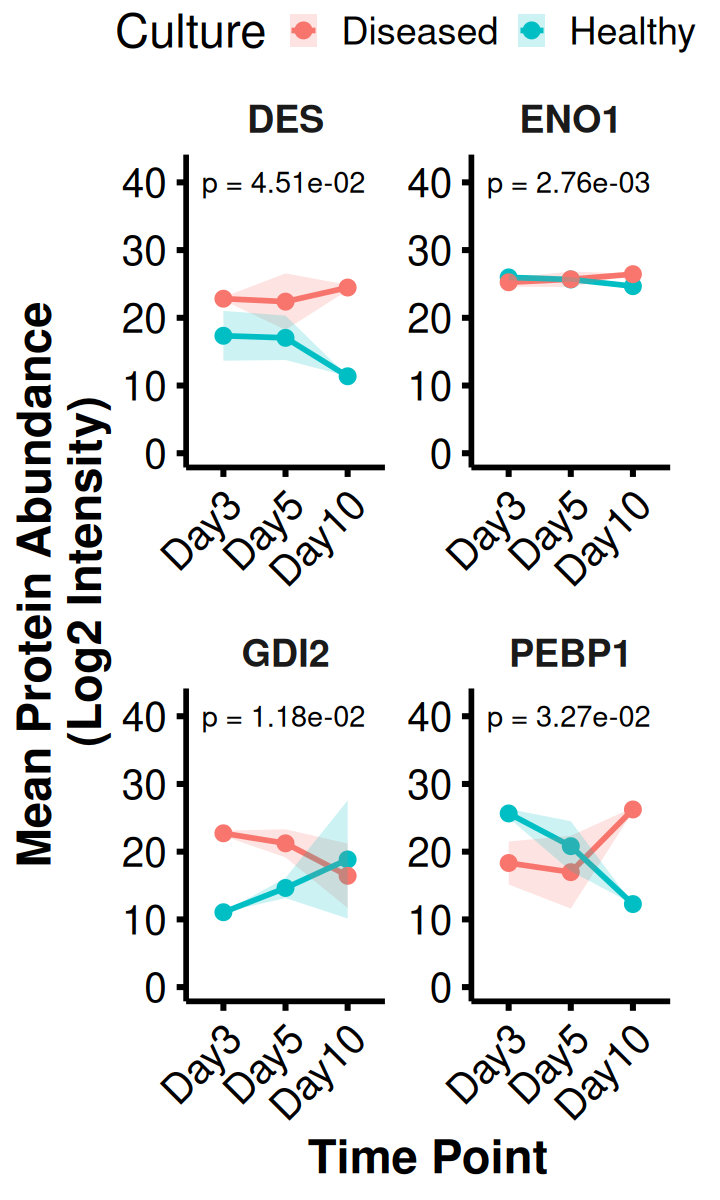

In [28]:
# Combine gene lists
combo <- c(a$gene, b$gene, d$gene)

# Subset corrected matrix
subset_corrected <- corrected[rownames(corrected) %in% combo, ]

# Initialize dataframe to store means and SDs
agg_df <- data.frame(Gene = rownames(subset_corrected))

# Define custom column indices for each group
group_indices <- list(
  Group1 = c(1,2,3),     # Day3 Healthy
  Group2 = c(4,5,6),     # Day3 Diseased
  Group3 = c(7,8,9),     # Day5 Healthy
  Group4 = c(10,11,12),  # Day5 Diseased
  Group5 = c(13,14,15),  # Day10 Healthy
  Group6 = c(18,17,18)   # Day10 Diseased
)

# Compute row-wise mean and SD using manual groups
for (group_name in names(group_indices)) {
  cols <- group_indices[[group_name]]
  group_data <- subset_corrected[, cols, drop = FALSE]
  
  agg_df[[paste0(group_name, "_mean")]] <- rowMeans(group_data, na.rm = TRUE)
  agg_df[[paste0(group_name, "_sd")]] <- apply(group_data, 1, sd, na.rm = TRUE)
}

# Reshape to long format
plot_df <- agg_df %>%
  pivot_longer(cols = -Gene, names_to = c("Group", "Stat"),
               names_pattern = "Group(\\d+)_(mean|sd)", values_to = "value") %>%
  pivot_wider(names_from = Stat, values_from = value) %>%
  mutate(
    Group = as.integer(Group),
    Time = case_when(
      Group %in% c(1, 2) ~ "Day3",
      Group %in% c(3, 4) ~ "Day5",
      Group %in% c(5, 6) ~ "Day10",
    ),
    Class = case_when(
      Group %% 2 == 1 ~ "Healthy",
      Group %% 2 == 0 ~ "Diseased"
    )
  )

# Split Healthy and Diseased
healthy_df <- plot_df %>% filter(Class == "Healthy") %>%
  mutate(TimePoint = Time)

diseased_df <- plot_df %>% filter(Class == "Diseased") %>%
  mutate(TimePoint = Time)

# Pivot to wide format
healthy_wide <- healthy_df %>%
  select(Gene, TimePoint, mean) %>%
  pivot_wider(names_from = Gene, values_from = mean)

diseased_wide <- diseased_df %>%
  select(Gene, TimePoint, mean) %>%
  pivot_wider(names_from = Gene, values_from = mean)

# Transpose to matrices
healthy_mat <- t(healthy_wide[, -1])
diseased_mat <- t(diseased_wide[, -1])
colnames(healthy_mat) <- healthy_wide$TimePoint
colnames(diseased_mat) <- diseased_wide$TimePoint
rownames(healthy_mat) <- colnames(healthy_wide)[-1]
rownames(diseased_mat) <- colnames(diseased_wide)[-1]

# Keep only shared genes
shared_genes <- intersect(rownames(healthy_mat), rownames(diseased_mat))
healthy_mat <- healthy_mat[shared_genes, , drop = FALSE]
diseased_mat <- diseased_mat[shared_genes, , drop = FALSE]

# Slope calculation function
get_slope <- function(df, gene, class = NULL) {
  gene_df <- df %>% filter(Gene == gene)
  if (!is.null(class)) {
    gene_df <- gene_df %>% filter(Class == class)
  }
  if (nrow(gene_df) < 2 || any(is.na(gene_df$mean))) return(NA)
  
  gene_df <- gene_df %>%
    mutate(TimeNum = as.numeric(gsub("Day", "", Time)))
  
  model <- lm(mean ~ TimeNum, data = gene_df)
  return(coef(model)[["TimeNum"]])
}

# ANCOVA interaction p-value
get_ancova_p <- function(df, gene) {
  gene_df <- df %>%
    filter(Gene == gene) %>%
    mutate(TimeNum = as.numeric(gsub("Day", "", Time)))
  
  if (nrow(gene_df) < 6 || any(is.na(gene_df$mean))) return(NA)
  
  model <- lm(mean ~ TimeNum * Class, data = gene_df)
  interaction_p <- anova(model)["TimeNum:Class", "Pr(>F)"]
  return(interaction_p)
}

# Slope ratios + ANCOVA
slope_ratio_df <- tibble(Gene = shared_genes) %>%
  rowwise() %>%
  mutate(
    slope_H = get_slope(healthy_df, Gene),
    slope_D = get_slope(diseased_df, Gene),
    slope_ratio = ifelse(!is.na(slope_H) & !is.na(slope_D) & slope_D != 0,
                         abs(slope_H / slope_D), NA_real_),
    direction = case_when(
      slope_H > 0 & slope_D < 0 ~ "H up, D down",
      slope_H < 0 & slope_D > 0 ~ "H down, D up",
      slope_H > slope_D ~ "H steeper",
      slope_D > slope_H ~ "D steeper",
      TRUE ~ "Similar"
    ),
    ancova_p = get_ancova_p(plot_df, Gene)
 ) %>%
  ungroup() %>%
  mutate(
    signif_stars = case_when(
      ancova_p < 0.001 ~ "***",
      ancova_p < 0.01 ~ "**",
      ancova_p < 0.05 ~ "*",
      TRUE ~ ""
    ),
    p_value_label = ifelse(!is.na(ancova_p),
                           paste0("p = ", formatC(ancova_p, format = "e", digits = 2)),
                           "p = NA"),
    label = paste0(p_value_label)
  ) %>%
  arrange(ancova_p)

# Merge both label and stars into plot_df
plot_df_labeled <- plot_df %>%
  left_join(slope_ratio_df %>% dplyr::filter(ancova_p < 0.05) %>% select(Gene, label, signif_stars) , by = "Gene") %>%  dplyr::filter(!is.na(label))

options(repr.plot.width =6, repr.plot.height =10)

p <- ggplot(plot_df_labeled, aes(x = factor(Time, levels=c("Day3","Day5", "Day10")), y = mean, color = Class, group = Class)) +
  geom_line(size = 1.2) +
  geom_point(size = 4) +
  geom_ribbon(aes(ymin = mean - sd, ymax = mean + sd, fill = Class),
              alpha = 0.2, color = NA) +
  # Add regular labels
  geom_text(data = . %>% group_by(Gene) %>% slice(1),
            aes(x = 0.65, y = 40, label = label),
            inherit.aes = FALSE, hjust = 0, size = 6) +
  facet_wrap(~ Gene, scales = "free", ncol = 2) +
  labs(
    x = "Time Point",
    y = "Mean Protein Abundance \n (Log2 Intensity)",
    color="Culture",
    group="Culture",
    fill="Culture"
  ) +
  theme_minimal(base_size = 28) +
  coord_cartesian(ylim = c(0, 42)) +
  theme(
    panel.grid = element_blank(),
    strip.text = element_text(face = "bold"),
    axis.line = element_line(size = 1.2, color = "black"),
    axis.line.y.right = element_blank(),
    axis.line.x.top = element_blank(),
    axis.ticks.length = unit(2, "mm"),
    axis.ticks = element_line(color = "black"),
    axis.title.x = element_text(face = "bold", size = 28, color = "black"),
    axis.title.y = element_text(face = "bold", size = 28, color = "black"),
    axis.text.x = element_text(size = 24, color = "black", angle = 45, hjust = 1),
    axis.text.y = element_text(size = 24, color = "black"),
    legend.position = c(0.45, 1.20),
    legend.justification = c("center", "top"),
  plot.margin = margin(t = 50, r = 30, b = 10, l = 10)  # top margin added
  )+
guides(
  color = guide_legend(ncol = 2, title.position="left", title.hjust=0.5),
  fill = guide_legend(ncol = 2, title.position="left", title.hjust=0.5),
  group = guide_legend(ncol=2, title.position="left", title.hjust=0.5)  
)
ggsave("time_series_no_day_7.jpeg", p,  dpi=300, height=10, width=6.3, unit="in")
p

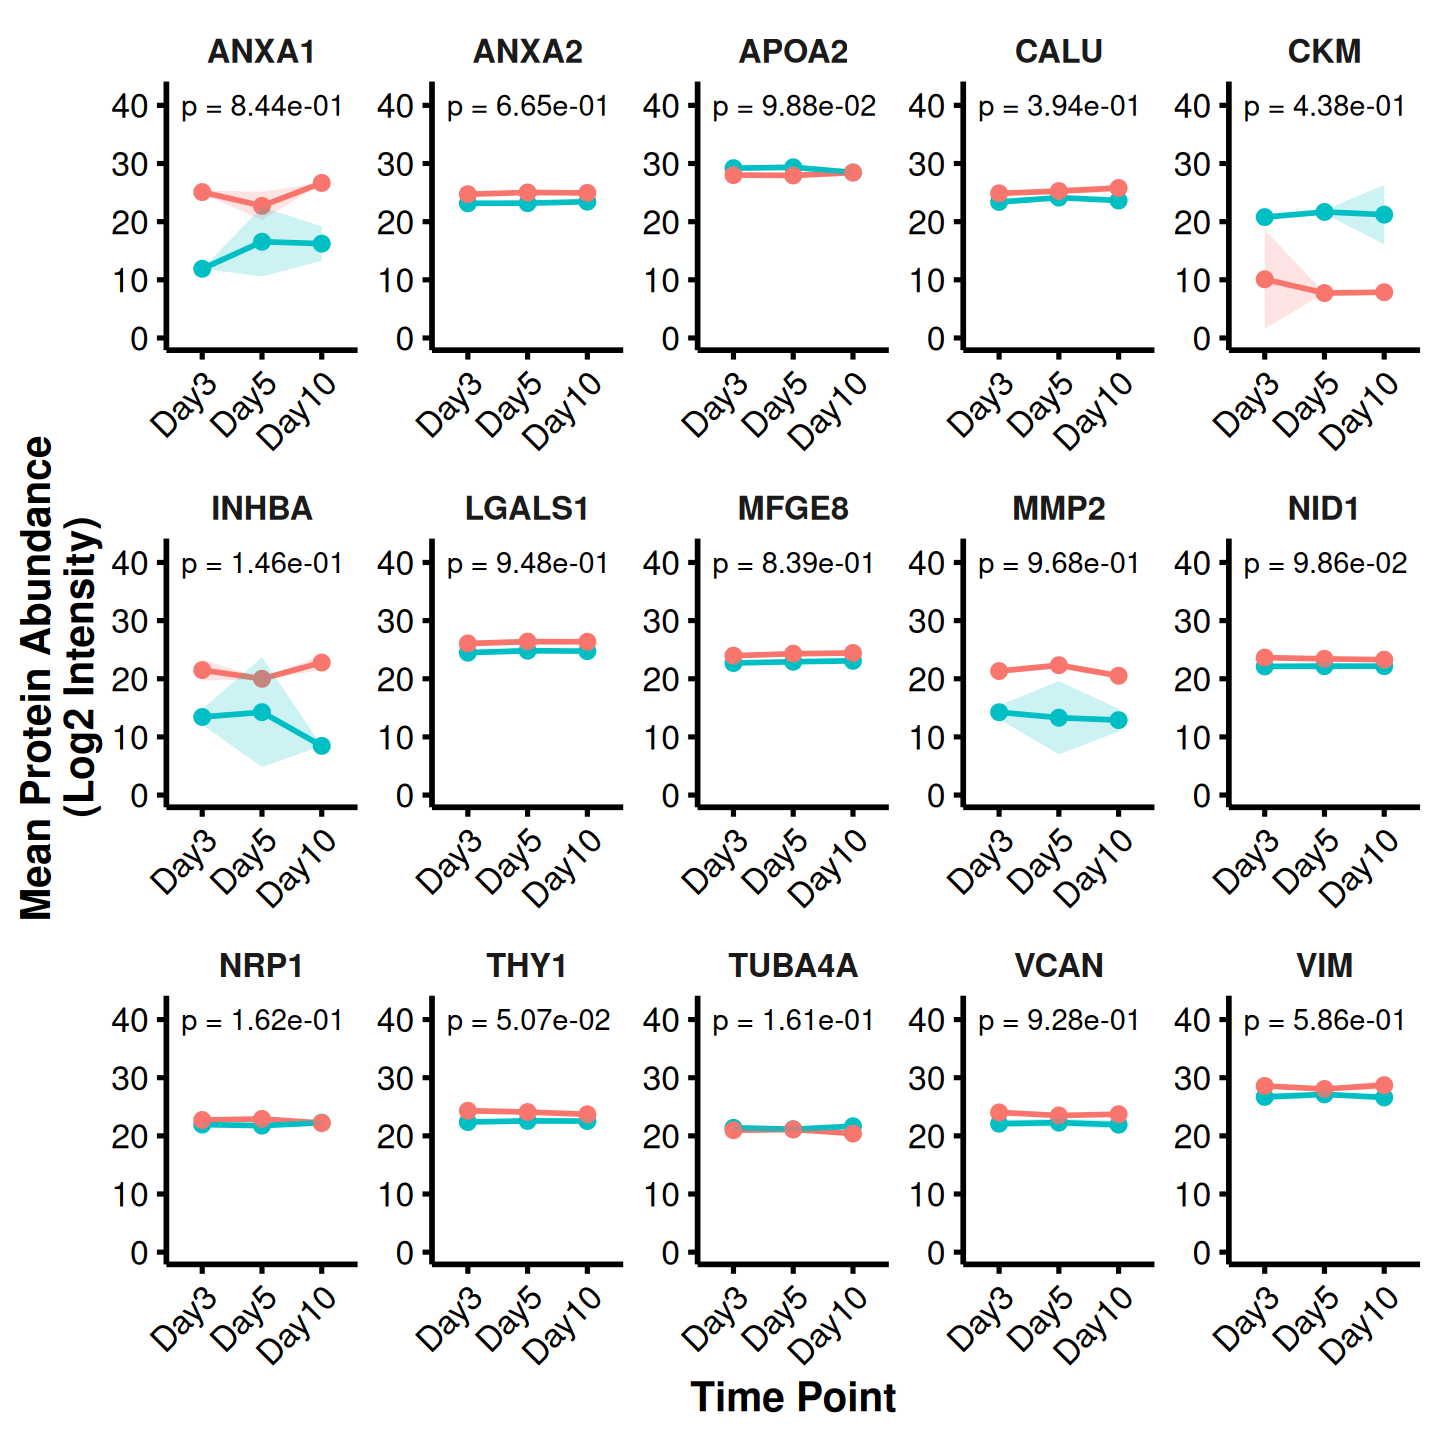

In [29]:
options(repr.plot.width =12, repr.plot.height =12)
# Merge both label and stars into plot_df
plot_df_labeled <- plot_df %>%
  left_join(slope_ratio_df %>% dplyr::filter(ancova_p > 0.05) %>% select(Gene, label, signif_stars) , by = "Gene") %>%  dplyr::filter(!is.na(label))


p <- ggplot(plot_df_labeled, aes(x = factor(Time, levels=c("Day3","Day5","Day10")), y = mean, color = Class, group = Class)) +
  geom_line(size = 1.2) +
  geom_point(size = 4) +
  geom_ribbon(aes(ymin = mean - sd, ymax = mean + sd, fill = Class),
              alpha = 0.2, color = NA) +
  # Add regular labels
  geom_text(data = . %>% group_by(Gene) %>% slice(1),
            aes(x = 0.65, y = 40, label = label),
            inherit.aes = FALSE, hjust = 0, size = 6) +
  facet_wrap(~ Gene, scales = "free", ncol = 5) +
  labs(
    x = "Time Point",
    y = "Mean Protein Abundance \n (Log2 Intensity)",
    color="Culture",
    group="Culture",
    fill="Culture"
  ) +
  theme_minimal(base_size = 24) +
  coord_cartesian(ylim = c(0, 42)) +
  theme(
    panel.grid = element_blank(),
    strip.text = element_text(face = "bold"),
    axis.line = element_line(size = 1.2, color = "black"),
    axis.line.y.right = element_blank(),
    axis.line.x.top = element_blank(),
    axis.ticks.length = unit(2, "mm"),
    axis.ticks = element_line(color = "black"),
    axis.title.x = element_text(face = "bold", size = 24, color = "black"),
    axis.title.y = element_text(face = "bold", size = 24, color = "black"),
    axis.text.x = element_text(size = 20, color = "black", angle = 45, hjust = 1),
    axis.text.y = element_text(size = 20, color = "black"),
    legend.position = c(0.45, 1.22),
    legend.justification = c("center", "top"),
  #plot.margin = margin(t = 50, r = 30, b = 10, l = 10)  # top margin added
  )+
guides(
  color = guide_legend(ncol = 2, title.position="top", title.hjust=0.5),
  fill = guide_legend(ncol = 2, title.position="top", title.hjust=0.5),
  group = guide_legend(ncol=2, title.position="top", title.hjust=0.5)  
)
ggsave("time_series_ns_no_day_7.jpeg", p,  dpi=300, height=12, width=14, unit="in")
p